# __Validations for single star ACA tracker simulator__

In [1]:
from __future__ import division
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from Quaternion import Quat
from astropy.table import Table
import Ska.Numpy
from Ska.engarchive import fetch_sci as fetch
from mica.archive.aca_l0 import get_l0_images, get_slot_data
from mica.archive import asp_l1
from Chandra.Time import DateTime
from Ska.Matplotlib import plot_cxctime
import cxotime
from chandra_aca.aca_image import ACAImage
from kadi import events
import mica.starcheck
from chandra_aca.transform import pixels_to_yagzag, yagzag_to_pixels, mag_to_count_rate, count_rate_to_mag
from Ska.quatutil import yagzag2radec, radec2yagzag
from agasc.agasc import get_agasc_cone

In [ ]:
# local imports:
import sys
sys.path.append(".")
import aca_simulate as sim
reload(sim)
from aca_simulate import ImgList

In [3]:
def get_telem(cat, slot):
    ok = (cat['slot'] == slot) * ((cat['type'] == 'BOT') + (cat['type'] == 'GUI'))
    yag, zag = cat['yang'][ok][0], cat['zang'][ok][0]
    mag, maxmag = cat['mag'][ok][0], cat['maxmag'][ok][0]
    return yag, zag, mag, maxmag


def as_array(attr, imgs):
    out = np.array([getattr(img, attr) for img in imgs])
    return out


def plot_star(star, c32=True):
    plt.imshow(star, interpolation='none', cmap='hot', vmin = -100, vmax=2300, origin='lower')
    plt.colorbar()
    plt.hlines(np.arange(0.5, 7.5), -0.5, 7.5, colors='y', linestyles='dotted')
    plt.vlines(np.arange(0.5, 7.5), -0.5, 7.5, colors='y', linestyles='dotted')
    if c32:
        c32 = np.array([1, 2, 2, 6, 6, 7, 7, 6, 6, 2, 2, 1, 1]) - 0.5
        r32 = np.array([2, 2, 1, 1, 2, 2, 6, 6, 7, 7, 6, 6, 2]) - 0.5
        plt.plot(c32, r32, '-', lw=2, color='w')
    plt.xlim(-0.5, 7.5)
    plt.ylim(-0.5, 7.5)
    plt.ylabel('Row')
    plt.xlabel('Column')
    plt.title('(ROW0, COL0) = ({:.0f}, {:.0f})'.format(row0, col0))
    return


def plot_set(imgs, start, vmin=-10, vmax=2000, num=4, grid6x6=False):
    for i in np.arange(start, start + num):
        plt.subplot(1, num, i - start + 1)
        plt.imshow(imgs[i], interpolation='none', origin='lower',
                   cmap='hot', vmin=vmin, vmax=vmax)
        if grid6x6:
            plt.hlines(np.arange(0.5, 5.5), -0.5, 5.5, colors='y', linestyles='dotted')
            plt.vlines(np.arange(0.5, 5.5), -0.5, 5.5, colors='y', linestyles='dotted')
        plt.xlabel('Column (px)')
        plt.ylabel('Row (px)')
    return


def centroids(img):
    img = np.array(img[1:7, 1:7])
    rw, cw = np.mgrid[0:6, 0:6] + 0.5
    img[[0, 0, 5, 5], [0, 5, 0, 5]] = 0.
    norm = np.sum(img)
    r = np.sum(rw * img) / norm
    c = np.sum(cw * img) / norm
    return r, c


class ObcAca(object):
    def __init__(self, start, stop, slot):
        self.yags = fetch.Msid('aoacyan{}'.format(slot), start, stop)
        self.zags = fetch.Msid('aoaczan{}'.format(slot), start, stop)
        self.funcs = fetch.Msid('aoacfct{}'.format(slot), start, stop)
        self.seqs = fetch.Msid('aoacaseq'.format(slot), start, stop)
        self.mags = fetch.Msid('aoacmag{}'.format(slot), start, stop)
        self.defpix = fetch.Msid('aoacidp{}'.format(slot), start, stop)
        self.multstars = fetch.Msid('aoacims{}'.format(slot), start, stop)
        self.t_aca = fetch.Msid('aach1t', start, stop)
        self.t_aca = np.mean(self.t_aca.vals)
        self.ok = (self.yags.vals > -3200) & (self.zags.vals > -3200)
        self.imgs = get_l0_images(start, stop, slot=slot,
                                   columns=['IMGROW0', 'IMGCOL0', 'BGDAVG', 'TIME'])
        self.row0s = as_array('IMGROW0', self.imgs)
        self.col0s = as_array('IMGCOL0', self.imgs)
        self.bgdavgs = as_array('BGDAVG', self.imgs)
        self.times = as_array('TIME', self.imgs)
        
    def __getattr__(imgs, attr):
        return np.array([getattr(img, attr) for img in imgs])

## FWHM ##

For FWHM of a typical ACA star assume value derived using Level-0 data, <code>FWHM = 2.77 pixels</code>. See fwhm.ipynb.

## Constants ###

In [4]:
FWHM = 2.77
GAIN = 5.
INTEG = 1.696

<img src='ACAImage-coordinates.jpg'>

##Obsid 8008##

In [5]:
obsid = 8008
d = events.dwells.filter(obsid=obsid)[0]
slot = 6
obc = ObcAca(d.start, d.stop, slot=slot)
sc = mica.starcheck.get_starcheck_catalog_at_date(d.start)
#quat = Quat([sc['manvr']['target_Q{}'.format(i)][0] for i in (1, 2, 3, 4)])
cat = sc['cat']
obs = sc['obs']
dither = {'dither_y_amp': obs['dither_y_amp'], 'dither_z_amp': obs['dither_z_amp'],
          'dither_y_period': obs['dither_y_period'], 'dither_z_period': obs['dither_z_period'],
          'dither_y_phase': 0., 'dither_z_phase': 0.}

In [6]:
# On-board quaternion
atts = fetch.MSIDset(['aoattqt*'], d.start, d.stop)
quat = Quat([atts['aoattqt{}'.format(i + 1)].vals[0] for i in range(4)])
quat

<Quat q1=0.14960202 q2=0.49089972 q3=0.83147544 q4=0.21280339>

In [7]:
yag, zag, mag, maxmag = get_telem(cat, slot)
print('Slot {}, guiding on star with:'.format(slot))
print('yag = {:.0f}, zag = {:.0f}, mag = {:.3f}, maxmag = {:.3f}'.format(yag, zag, mag, maxmag))

Slot 6, guiding on star with:
yag = 890, zag = -1600, mag = 8.641, maxmag = 10.141


In [8]:
obc.mags.times[1] - obc.mags.times[0], obc.mags.times[0]

(1.0250000357627869, 284100553.48501438)

In [9]:
obc.times[1] - obc.times[0], obc.times[0]

(2.0500001311302185, 284100554.68701398)

In [10]:
atts['aoattqt1'].times[0] - obc.times[0], atts['aoattqt1'].times[0]

(-1.2019996047019958, 284100553.48501438)

### Simulate a single star ###

* Simulation of star corresponding to the first frame in Obsid 8008, and comparison with the telemetry.
* Star is modeled as a 2-D Gaussian with FWHM = 2.77 (derived based on Level-0 data).
* ACA readout window is defined with row0, col0 (between -511 and 512) and sz (6 or 8 pixels).
* Star location in ACA readout window is derived from star's ra, dec and spacecraft attitude quaternion.
* Mouse-bitten 6x6 region is used to convert between counts and mags.

__Issues__

* Magnitude in telemetry: computed from 32 pixels or 8x8?

In [11]:
reload(sim)
sz = 8
row0 = obc.row0s[0]
col0 = obc.col0s[0]
# OBC
star_obc = np.zeros((8, 8))
star_obc[1:-1, 1:-1] = obc.imgs[0]
# Simulation 1: star parameters from telemetry
ra1, dec1 = yagzag2radec(obc.yags.vals[0] / 3600., obc.zags.vals[0] / 3600., quat)
mag1 = obc.mags.vals[0]
star1 = sim.simulate_star(quat, ra1, dec1, mag1, row0, col0, sz)
# Simulation 2: star params (yag, zag, mag, quat) from catalog
ra2, dec2 = yagzag2radec(yag / 3600., zag / 3600., quat)
star2 = sim.simulate_star(quat, ra2, dec2, mag, row0, col0, sz)

OBC (left): (r, c) = (3.239, 3.387)
    Counts - 32 * bgdavg = 8578.03125
    Mag: 8.641
Simulation 1 (middle): (r, c) = (3.216, 3.350)
    Counts: 9814
    Mag: 8.470
    dyag = 0.000 arcsec, dzag = 0.000 arcsec
    dr = -0.024 px ,  dc = -0.037 px
Simulation 2 (right): (r, c) = (2.689, 1.951)
    Counts: 8770
    Mag: 8.592
    dyag = 2.925 arcsec, dzag = -7.975 arcsec
    dr = -0.551 px ,  dc = -1.436 px


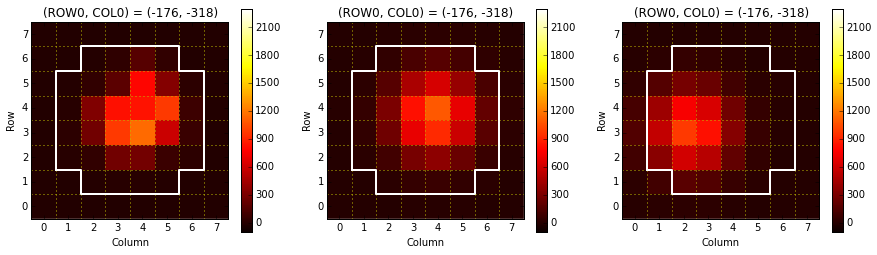

In [12]:
plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plot_star(star_obc - obc.bgdavgs[0])
plt.subplot(1, 3, 2)
plot_star(star1)
plt.subplot(1, 3, 3)
plot_star(star2)
row_obc, col_obc = yagzag_to_pixels(obc.yags.vals[0], obc.zags.vals[0])
r_obc = row_obc - row0
c_obc = col_obc - col0
row1_sim, col1_sim = yagzag_to_pixels(yag, zag)
r_sim1, c_sim1 = centroids(star1)
r_sim2, c_sim2 = centroids(star2)

print('OBC (left): (r, c) = ({:.3f}, {:.3f})'.format(r_obc, c_obc))
print('    Counts - 32 * bgdavg = {}'.format(np.sum(obc.imgs[0]) - 32 * obc.bgdavgs[0]))
print('    Mag: {}'.format(mag))

print('Simulation 1 (middle): (r, c) = ({:.3f}, {:.3f})'.format(r_sim1, c_sim1))
print('    Counts: {:.0f}'.format(np.float(np.sum(star1))))
print('    Mag: {:.3f}'.format(np.float(count_rate_to_mag(np.sum(star1) * GAIN / INTEG))))
print('    dyag = {:.3f} arcsec, dzag = {:.3f} arcsec'.format(0., 0.))
print('    dr = {:.3f} px ,  dc = {:.3f} px'.format(r_sim1 - r_obc, c_sim1 - c_obc))

print('Simulation 2 (right): (r, c) = ({:.3f}, {:.3f})'.format(r_sim2, c_sim2))
print('    Counts: {:.0f}'.format(np.float(np.sum(star2))))
print('    Mag: {:.3f}'.format(np.float(count_rate_to_mag(np.sum(star2) * GAIN / INTEG))))
print('    dyag = {:.3f} arcsec, dzag = {:.3f} arcsec'.format(yag - obc.yags.vals[0], zag - obc.zags.vals[0]))
print('    dr = {:.3f} px ,  dc = {:.3f} px'.format(r_sim2 - r_obc, c_sim2 - c_obc))

__Figure.__ _Left:_ OBC telemetry. Middle: Star image simulated using OBC's yag, zag, mag, quat. _Right:_ Star image simulated using catalog yag, zag, mag, quat. Simulation using catalog yag, zag, mag, quat (right) results in (dyag, dzag) = (2.9, -8.0) arcsec or (dr, dc) = (-0.6, -1.4) px with respect to the telemetered values (left). Pointing uncertainties?

### Simulate stars around the catalog position of the star of interest### 

* Fetch agasc stars within the given radius from the intial (catalog) yag and zag, fiven initial quat.
* Simulate the intial star field including dark background (with 2 * radius).
* For each time step:
    * dither => dyaw, dpitch => dquat
    * dquat => next quat
    * dquat => dRA and dDEC, and next RA, DEC coordinates => next yag, zag (true) coordinates
    * predict next row0, col0
    * construct next ACA readout window (ACAImage)
    * simulate agasc star(s) and add dark background using next coordinates and get the section corresponding to the next readout window
    * compute centroids and img_sums (~mag) for the next image
* ACA dark background is computed from kwargs argument _dark_: None (default, use the most recent), date, or 1024x1024 array. Dark background is scaled with temperature given by t_ccd (default None, no scaling). 

__Choose an observation with spoiler stars__<br>
See Obsid NONE2, https://icxc.cfa.harvard.edu/mp/mplogs/2015/JUL1015/oflsb/starcheck.html. To the right of star number 5 there is a faint 10.89 mag star in the center, and two spoiler star with mags 8.06 and 9.86.

<img src='stars_NONE2.png'>

In [ ]:
reload(sim)
quat1 = Quat([280, 0.5, 201.675669])
yag1, zag1, mag1 = 1214.79, 1042.90, 8.06
ra1, dec1 = yagzag2radec(yag1 / 3600., zag1 / 3600., quat1)
kwargs = {'dark': '2015:200'}
stars1 = get_agasc_cone(ra1, dec1, radius=120./3600)
star_field1 = sim.simulate_star_field(stars1, quat1, yag1, zag1, radius=150., **kwargs)

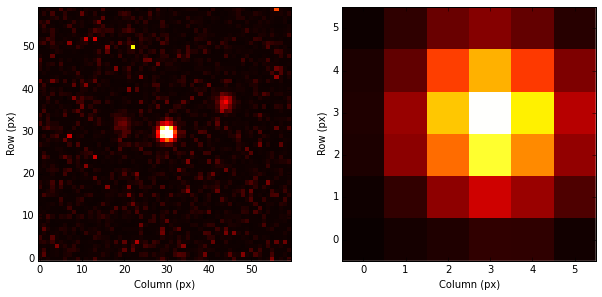

In [14]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)

plt.imshow(star_field1, interpolation='none', origin='lower', cmap='hot', vmax=1000)
plt.xlabel('Column (px)')
plt.ylabel('Row (px)');

plt.subplot(1, 2, 2)

r0 = np.round(star_field1.row0 + star_field1.IMGSIZE / 2 - 3)
c0 = np.round(star_field1.col0 + star_field1.IMGSIZE / 2 - 3)
cut = ACAImage(row0=r0, col0=c0, shape=(6, 6))
plt.imshow(star_field1[cut], interpolation='none', cmap='hot', origin='lower');
plt.xlabel('Column (px)')
plt.ylabel('Row (px)');


__Figure.__ _Left:_ Simulated star field. _Right_: This is to verify if star is in the center of a 6x6 readout window centered at (yag, zag).

## Back to Obsid 8008 ##

In [15]:
reload(sim)
ra, dec = yagzag2radec(yag / 3600., zag / 3600., quat)
stars = get_agasc_cone(ra, dec, radius=40./3600)
kwargs = {'dark': d.start}
star_field = sim.simulate_star_field(stars, quat, yag, zag, radius=40., **kwargs)
# print(star_field.meta)

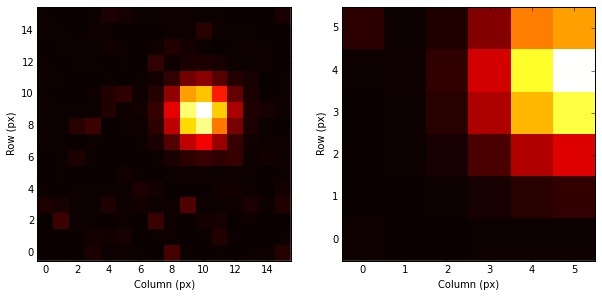

In [16]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)

plt.imshow(star_field, interpolation='none', origin='lower', cmap='hot', vmax=1000)
plt.xlabel('Column (px)')
plt.ylabel('Row (px)');

plt.subplot(1, 2, 2)

r0 = np.round(star_field.row0 + star_field.IMGSIZE / 2 - 3)
c0 = np.round(star_field.col0 + star_field.IMGSIZE / 2 - 3)
cut = ACAImage(row0=r0, col0=c0, shape=(6, 6))
plt.imshow(star_field[cut], interpolation='none', cmap='hot', origin='lower');
plt.xlabel('Column (px)')
plt.ylabel('Row (px)');

__Figure.__ _Left:_ Simulated star field. _Right_: This is to verify if star is in the center of a 6x6 readout window centered at (yag, zag): there is a 1-2 px ~ 5-10 arcsec offset in both row and col.

__Repeat with the first OBC yag, zag and quat (instead of catalog yag, zag, quat)__<br>
Same result because in the simulate_guide the stars are simulated at the RA, DEC found by agasc, as opposed to the 'simulate a single star' example above.

### Star field simulator combined with star tracker###

In [17]:
#y: 0.42, 2; z: 0.12, -8
dither['dither_y_phase'] = 0.42
dither['dither_z_phase'] = 0.12
kwargs = {'nframes': 500, 'radius': 40., 'imgsize': 6, 'dither': dither, 'dark': d.start}

In [18]:
reload(sim)
guide = sim.simulate_guide(quat, yag, zag, maxmag=maxmag, **kwargs)

({'dither_z_phase': 0.12, 'dither_y_phase': 0.42, 'dither_y_period': 1000.0, 'dither_z_amp': 8.0, 'dither_z_period': 707.1, 'dither_y_amp': 8.0}, 890, -1600, <Quat q1=0.14960202 q2=0.49089972 q3=0.83147544 q4=0.21280339>)


In [19]:
guide.keys()

['funcs',
 'dyags',
 'true_zags',
 'aca_yags',
 'true_ras',
 'col0s',
 'true_decs',
 'aca_zags',
 'imgraws',
 'aca_mags',
 'quats',
 'true_yags',
 'stars',
 'time',
 'row0s',
 'dzags',
 'bgdavgs']

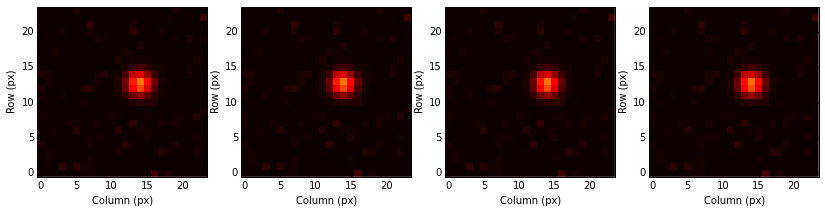

In [20]:
plt.figure(figsize=(14, 5))
start, num = 4, 4
plot_set(guide['stars'], start=start, num=num)

__Figure.__ Dictionary <code>guide</code> contains a key _stars_ to store the original star field images.

In [21]:
print('Star has been tracked. Min/Max values of row0s and col0s of ACA readout windows:')
print(guide['row0s'].min(), guide['row0s'].max(), guide['col0s'].min(), guide['col0s'].max())

print('\nMin/Max values of row0s and col0s of original star fields:')
stars_row0s = [star.row0 for star in guide['stars']]
stars_col0s = [star.col0 for star in guide['stars']]
print(np.min(stars_row0s), np.max(stars_row0s))
print(np.min(stars_col0s), np.max(stars_col0s))

Star has been tracked. Min/Max values of row0s and col0s of ACA readout windows:
(-177.0, -174.0, -319.0, -316.0)

Min/Max values of row0s and col0s of original star fields:
(-189.0, -185.0)
(-329.0, -327.0)


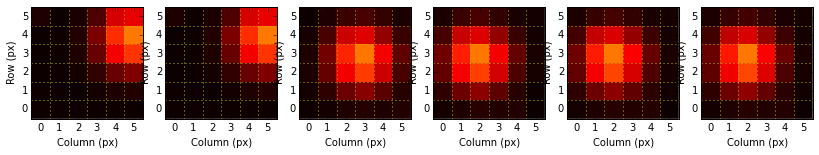

In [22]:
plt.figure(figsize=(14, 5))
start, num = 0, 6
plot_set(guide['imgraws'], start=start, num=num, grid6x6=True)
#for ii in range(num):
#    print('(ROW0, COL0) = ({}, {})'.format(guide['row0s'][ii + start], guide['col0s'][ii + start]))

__Figure.__ Dictionary <code>guide</code> contains key _imgraws_ to store the 6x6 (8x8) images used for tracking and computing the centroids. Keys _row0s_, _col0s_ contain values defining the location of these images on ACA CCD. Note the 2-3px offset between the 'true' centroid and simulated centroid in the left-most image (image at t=0). This could be due to pointing errors, or an error on the order of imgsize/2 while simulating the star field.

In [23]:
# print('Keys dyags (dzags) reflect difference between')
# print('- true_yags/zags (derived from initial yag, zag, quat) and')
# print('- aca_yags/zags (derived from simulated images)\n')
# start, num = 300, 10
# for ii in range(num):
#    print('(dyag, dzag) = ({:.1f}, {:.1f}) arcsec'.format(guide['dyags'][ii + start], guide['dzags'][ii + start]))

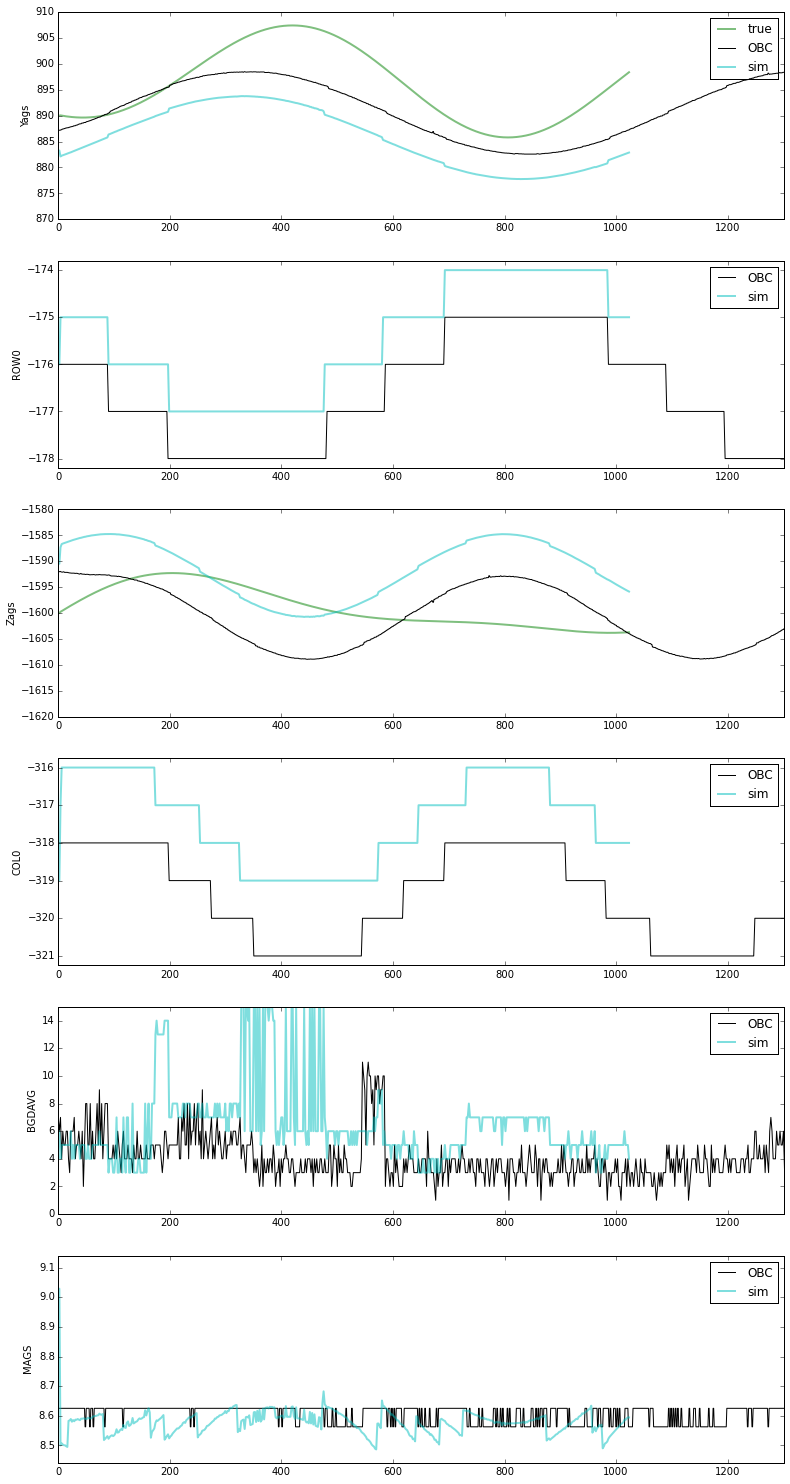

In [24]:
plt.figure(figsize=(13, 26))

plt.subplot(6, 1, 1)

plt.plot(guide['time'], guide['true_yags'], 'g', lw=2, alpha=0.5, label='true')
plt.plot(obc.yags.times - obc.yags.times[0], obc.yags.vals, 'k', label='OBC')
plt.plot(guide['time'], guide['aca_yags'], 'c', lw=2, alpha=0.5, label='sim')
plt.legend()
plt.ylabel('Yags')
plt.xlim(0, 1300)
plt.ylim(yag - 20, yag + 20);

plt.subplot(6, 1, 2)

plt.plot(obc.times - obc.times[0], obc.row0s, 'k', label='OBC')
plt.plot(guide['time'], guide['row0s'], 'c', lw=2, alpha=0.5, label='sim')
plt.legend()
plt.ylabel('ROW0')
plt.xlim(0, 1300)
plt.margins(0.05);

plt.subplot(6, 1, 3)

plt.plot(guide['time'], guide['true_zags'], 'g', lw=2, alpha=0.5)
plt.plot(obc.zags.times - obc.zags.times[0], obc.zags.vals, 'k')
plt.plot(guide['time'], guide['aca_zags'], 'c', lw=2, alpha=0.5)
plt.ylabel('Zags')
plt.xlim(0, 1300)
plt.ylim(zag - 20, zag + 20);

plt.subplot(6, 1, 4)

plt.plot(obc.times - obc.times[0], obc.col0s, 'k', label='OBC')
plt.plot(guide['time'], guide['col0s'], 'c', lw=2, alpha=0.5, label='sim')
plt.legend()
plt.ylabel('COL0')
plt.xlim(0, 1300)
plt.margins(0.05);

plt.subplot(6, 1, 5)

plt.plot(obc.times - obc.times[0], obc.bgdavgs, 'k', label='OBC')
plt.plot(guide['time'], guide['bgdavgs'], 'c', lw=2, alpha=0.5, label='sim')
plt.ylabel('BGDAVG')
plt.legend()
plt.xlim(0, 1300)
plt.ylim(0, 15);

plt.subplot(6, 1, 6)

plt.plot(obc.mags.times - obc.mags.times[0], obc.mags.vals, 'k', label='OBC')
plt.plot(guide['time'], guide['aca_mags'], 'c', lw=2, alpha=0.5, label='sim')
plt.ylabel('MAGS')
plt.legend()
plt.xlim(0, 1300)
plt.ylim(mag - 0.2, mag + 0.5);

__Figure.__<br>
* I do not understand the weird shape of 'true' yags, zags (green). Computed as: dyaw, dpitch => dquat, new quat => dRA, dDEC => new RA, DEC => new (true) yag, zag.
* Simulations (cyan) match OBC telemetry (black) in phase after adjusting y, z phases 'by eye'.
* Simulated yags, zags and row0s, col0s (cyan) match OBC telemetry (black) to 1-2 px (5-10 arcsec) accuracy. I believe this stems from the fact that the star is simulated at agasc coordinates that are off from the catalog yag/zag (see 'simulate stars' example above).
* Simulated background will not match exactly OBC's bdgavg because the simulated values are based on a dark current map.
* Simulated magnitudes appear to match OBC telemetry.

## Dither ##

In [25]:
nframes, imgsize = 2000, 6
delta_t = {4: 2.05, 6: 2.05, 8: 4.1}
times = np.arange(nframes) * delta_t[imgsize]

yaw = sim.calc_dither(times,
                  dither['dither_y_amp'],
                  dither['dither_y_period'],
                  dither['dither_y_phase'])
pitch = sim.calc_dither(times,
                    dither['dither_z_amp'],
                    dither['dither_z_period'],
                    dither['dither_z_phase'])

In [26]:
true_yags = np.zeros(nframes)
true_zags = np.zeros(nframes)
quats = [quat]
true_yags[0] = yag
true_zags[0] = zag
ra, dec = yagzag2radec(yag / 3600., zag / 3600., quat)

for ii in range(1, nframes):
    dy, dp = yaw[ii] - yaw[ii - 1], pitch[ii] - pitch[ii - 1]
    dq = Quat([dy / 3600., -dp / 3600., 0.])
    ra = ra + dq.ra0
    dec = dec + dq.dec
    quats.append(quats[ii - 1] * dq)
    y, z = radec2yagzag(ra, dec, quats[ii])
    true_yags[ii] = y * 3600.
    true_zags[ii] = z * 3600.

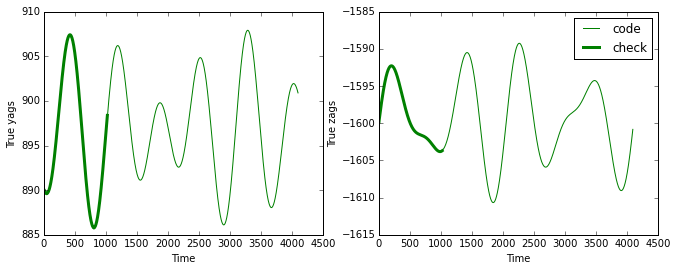

In [27]:
plt.figure(figsize=(11, 4))
plt.subplot(1, 2, 1)
plt.plot(times - times[0], true_yags, 'g')
plt.plot(guide['time'] - guide['time'][0], guide['true_yags'], 'g', lw=3)
plt.ylabel('True yags');
plt.xlabel('Time');
plt.subplot(1, 2, 2)
plt.plot(times, true_zags, 'g', label='code')
plt.plot(guide['time'] - guide['time'][0], guide['true_zags'], 'g', lw=3, label='check')
plt.ylabel('True zags');
plt.xlabel('Time')
plt.legend();